In [1]:
# TO DO: analyze different methods, especially at different points of the match

# REWRITE THE PROBABILITY COMPUTATIONS??
# test each method on a subset of matches, via tourney_id

# TO DO: test a grid search of averaging historical with overall player percentages and see if any split (50-50,70-30,etc)
# then, run grid search on alpha parameter, for beta distribution
# run grid search on coefficients for combining elo/s_elo with serve percentages

# see if player performance can predict performance at certain stages of the match

# then, apply all these methods to find the probability of winning the next point, game, set

# The numbers I used for men are: 63% in Australia, 61% at the French, 66% at Wimbledon, and 64% at the U.S. Open

In [6]:
import sys
sys.path.insert(0,'/Users/jacobgollub/Desktop/college (current)/research/pbp_explorations/scripts/sackmann')
import tennisGameProbability,tennisMatchProbability,tennisSetProbability,tennisTiebreakProbability
from tennisMatchProbability import matchProb
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss

f_av = 0.646775
g_av = 1 - f_av
df = pd.read_csv('../my_data/feature_df_pbp3_9_6_alphas.csv')
del df['Unnamed: 0']
# cols = [u'match_id',u'sets_0',u'sets_1', u'games_0', u'games_1', u'points_0', u'points_1','p0_s_pct','p0_r_pct',
#         'p1_s_pct','p1_r_pct','p0_s_kls','p1_s_kls','p0_s_kls_JS','p1_s_kls_JS',u'p0_swp', u'p0_sp', u'p1_swp', u'p1_sp',
#         'tourney_stats','tourney_id','best_of',u'winner']
# df = df[cols]

In [8]:
#df.to_csv('../my_data/feature_df_pbp3_8_23_alphas.csv')

In [7]:
zero_index = df[df['winner']==0].index
one_index = df[df['winner']==1].index

best_prob = np.zeros(len(df))
best_prob[zero_index] = np.minimum(df['klaassen_prob'][zero_index],df['klaassen_prob_JS'][zero_index])
best_prob[one_index] = np.maximum(df['klaassen_prob'][one_index],df['klaassen_prob_JS'][one_index])
df['best_prob'] = best_prob

In [8]:
from sklearn.metrics import log_loss,accuracy_score

n = len(df)

# a=400 works the best
print 'sackmann score: ',log_loss(df['winner'][:n],df['sackmann_prob'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['sackmann_prob'][:n]>=.5)
print 'klaassen score: ',log_loss(df['winner'][:n],df['klaassen_prob'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob'][:n]>=.5)
print 'klaassen score JS: ',log_loss(df['winner'][:n],df['klaassen_prob_JS'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_JS'][:n]>=.5)
print 'best score of both: ',log_loss(df['winner'][:n],best_prob[:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],best_prob[:n]>=.5)
print 'klaassen score, a=200: ',log_loss(df['winner'][:n],df['klaassen_prob_a_200'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_200'][:n]>=.5)
print 'klaassen score, a=300: ',log_loss(df['winner'][:n],df['klaassen_prob_a_300'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_300'][:n]>=.5)
print 'klaassen score, a=400: ',log_loss(df['winner'][:n],df['klaassen_prob_a_400'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_400'][:n]>=.5)
print 'klaassen score, a=500: ',log_loss(df['winner'][:n],df['klaassen_prob_a_500'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_500'][:n]>=.5)
print 'klaassen score, a=600: ',log_loss(df['winner'][:n],df['klaassen_prob_a_600'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_600'][:n]>=.5)
print 'klaassen score, a=1000: ',log_loss(df['winner'][:n],df['klaassen_prob_a_1000'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_a_1000'][:n]>=.5)

sackmann score:  0.532342264747 0.723431958815
klaassen score:  0.45577976703 0.779044643829
klaassen score JS:  0.463413575375 0.776334108236
best score of both:  0.44600366264 0.784485209427
klaassen score, a=200:  0.455376795184 0.77661271588
klaassen score, a=300:  0.454484664311 0.7778993471
klaassen score, a=400:  0.454355081829 0.77846468506
klaassen score, a=500:  0.454401421032 0.778686434001
klaassen score, a=600:  0.454490484705 0.7788423893
klaassen score, a=1000:  0.454824492266 0.779017026745


In [9]:
zero_set_ind = np.zeros(n)
one_set_ind = np.zeros(n)
two_set_ind = np.zeros(n)

for i,row in df.iterrows():
    s = row['sets_0']+row['sets_1']
    if s==0:
        zero_set_ind[i] = 1
    elif s==1:
        one_set_ind[i] = 1
    elif s==2:
        two_set_ind[i] = 1
    else:
        print 'hi'

zero_set_ind,one_set_ind,two_set_ind = np.where(zero_set_ind==1)[0],np.where(one_set_ind==1)[0],np.where(two_set_ind==1)[0]

In [10]:
# include this in your analysis; the klaassen model is almost as bad at predicting in the third set 
# as it is in the first set (this should be improved with beta experiments)
print 'klaassen score first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob'][zero_set_ind],labels=[0,1])
print 'klaassen score JS first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob_JS'][zero_set_ind],labels=[0,1])
print 'klaassen score second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob'][one_set_ind],labels=[0,1])
print 'klaassen score JS second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob_JS'][one_set_ind],labels=[0,1])
print 'klaassen score third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob'][two_set_ind],labels=[0,1])
print 'klaassen score JS third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob_JS'][two_set_ind],labels=[0,1])

klaassen score first set:  0.522095728468
klaassen score JS first set:  0.533454837295
klaassen score second set:  0.375290435583
klaassen score JS second set:  0.380682234946
klaassen score third set:  0.492594419836
klaassen score JS third set:  0.495827584932


In [12]:
df

,match_id,elo_diff,s_elo_diff,winner,p0_s_pct,p0_s_pct_JS,p1_s_pct,p1_s_pct_JS,p0_r_pct,p0_r_pct_JS,...,klaassen_prob,klaassen_prob_JS,klaassen_prob_a_100,klaassen_prob_a_200,klaassen_prob_a_300,klaassen_prob_a_400,klaassen_prob_a_500,klaassen_prob_a_600,klaassen_prob_a_1000,best_prob
0,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.694988,0.659458,0.694988,0.694988,0.694988,0.694988,0.694988,0.694988,0.694988,0.659458
1,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.702530,0.668623,0.713761,0.708204,0.706325,0.705381,0.704813,0.704434,0.703674,0.668623
2,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.707400,0.674816,0.729028,0.718441,0.714812,0.712978,0.711872,0.711132,0.709646,0.674816
3,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.709770,0.677997,0.741238,0.726001,0.720704,0.718013,0.716385,0.715294,0.713098,0.677997
4,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.710384,0.678894,0.751358,0.731736,0.724817,0.721284,0.719140,0.717701,0.714799,0.678894
5,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.701581,0.668720,0.730339,0.716579,0.711723,0.709242,0.707736,0.706725,0.704685,0.668720
6,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.695415,0.661382,0.711689,0.703940,0.701189,0.699779,0.698923,0.698348,0.697186,0.661382
7,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.692108,0.657310,0.695745,0.694081,0.693459,0.693135,0.692937,0.692802,0.692529,0.657310
8,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.691115,0.656026,0.681992,0.686459,0.687990,0.688763,0.689230,0.689542,0.690169,0.656026
9,0.0,-201.699915,-152.190884,0.0,0.684783,0.661407,0.625532,0.626782,0.327586,0.343856,...,0.699322,0.666056,0.699801,0.699713,0.699619,0.699558,0.699518,0.699489,0.699427,0.666056


In [108]:
# include this in your analysis; the klaassen model is almost as bad at predicting in the third set 
# as it is in the first set (this should be improved with beta experiments)
print 'klaassen score first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob'][zero_set_ind],labels=[0,1])
print 'klaassen score JS first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob_JS'][zero_set_ind],labels=[0,1])
print 'klaassen score second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob'][one_set_ind],labels=[0,1])
print 'klaassen score JS second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob_JS'][one_set_ind],labels=[0,1])
print 'klaassen score third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob'][two_set_ind],labels=[0,1])
print 'klaassen score JS third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob_JS'][two_set_ind],labels=[0,1])

klaassen score first set:  0.526703165004
klaassen score JS first set:  0.538227097605
klaassen score second set:  0.379751243889
klaassen score JS second set:  0.385387382417
klaassen score third set:  0.509062169893
klaassen score JS third set:  0.512340971903


In [95]:
# TO DO: provide the same breakdown by surface, surface and set...





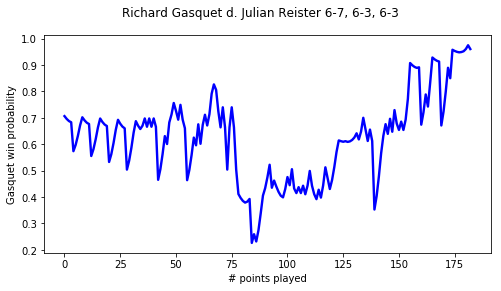

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

match1 = df[df['match_id']==1]
m1_probs = match1['klaassen_prob']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Gasquet win probability')
ax.set_xlabel('# points played')
#plt.savefig('gasquet_reister_7_14_all_features')
fig.show()

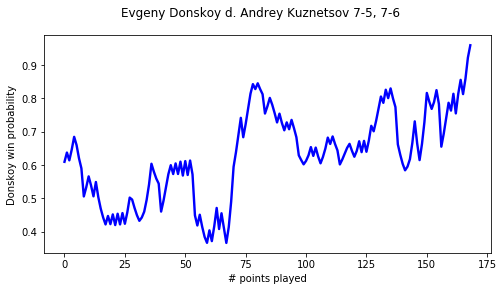

In [88]:
match2 = df[df['match_id']==2]
m2_probs = match2['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m2_probs)),1-m2_probs,'b-',linewidth=2.4)
fig.suptitle('Evgeny Donskoy d. Andrey Kuznetsov 7-5, 7-6')
ax.set_ylabel('Donskoy win probability')
ax.set_xlabel('# points played')
fig.show()

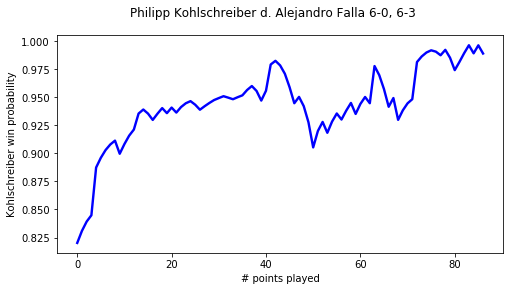

In [86]:
match5 = df[df['match_id']==4]
m5_probs = match5['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m5_probs)),m5_probs,'b-',linewidth=2.4)
fig.suptitle('Philipp Kohlschreiber d. Alejandro Falla 6-0, 6-3')
ax.set_ylabel('Kohlschreiber win probability')
ax.set_xlabel('# points played')
fig.show()

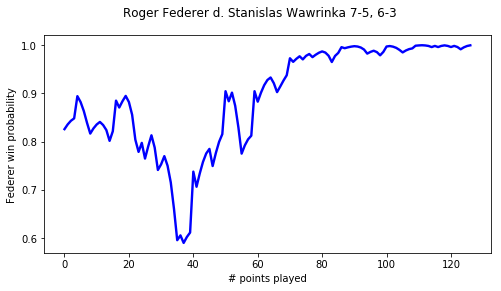

In [89]:
match10 = df[df['match_id']==10439]
m10_probs = match10['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m10_probs)),m10_probs,'b-',linewidth=2.4)
fig.suptitle('Roger Federer d. Stanislas Wawrinka 7-5, 6-3')
ax.set_ylabel('Federer win probability')
ax.set_xlabel('# points played')
fig.show()

In [18]:
from sklearn.metrics import log_loss
# evaluate log_loss of these probabilities (log_loss(y_true,y_pred))
# we get .54 log_loss with no information about the players... (around .48 was best with most recent features)

# n=len(df)
# score = log_loss(df['winner'][:n],df['sackmann_prob'][:n],labels=[0,1])
# print 'sackmann score: ',score

k_df = df[df['klaassen_prob']==df['klaassen_prob']]
k_score = log_loss(k_df['winner'][:n],k_df['klaassen_prob'][:n],labels=[0,1])
print 'klaassen score: ',k_score
#df.to_csv('../my_data/feature_df_pbp3_7_30_s_prob.csv')

sackmann score:  0.538905529928
klaassen score:  0.591980500589


In [ ]:
# when we don't use a prior, or assign weights to evidence, we get serving percentages like this one...
# Tursunov's 25/32 return percentage was way the hell too high
df['match_id'][760117],df['p0_s_kls'][760117]

In [ ]:
# import pandas as pd
# import numpy as np

# # storing coefficients for serve and return shrinkage in dicts
# df_0 = pd.read_csv('../my_data/elo_pbp_with_surface_8_14.csv')

# # calculate B_i coefficients for each player in terms of service points; since serve and return points are approximately
# # equal, we use the same coefficient for both
# s_history = np.concatenate([df_0['p0_52_swon']/df_0['p0_52_svpt'],df_0['p1_52_swon']/df_0['p1_52_svpt']],axis=0)
# p_hat = np.sum([df_0['p0_52_swon'],df_0['p1_52_swon']])/np.sum([df_0['p0_52_svpt'],df_0['p1_52_svpt']])
# sigma2_i = np.nan_to_num(p_hat*(1-p_hat)/np.concatenate([df_0['p0_52_svpt'],df_0['p1_52_svpt']]))
# tau2_hat = np.nanvar(s_history)
# B_i = sigma2_i/(tau2_hat+sigma2_i)
# df_0['B_i0_sv'],df_0['B_i1_sv'] = B_i[::2],B_i[1::2]

# n = len(s_history)/2
# s_history[s_history!=s_history] = p_hat
# df_0['p0_s_pct_JS'] = s_history[:n]+df_0['B_i0_sv']*(p_hat-s_history[:n])
# df_0['p1_s_pct_JS'] = s_history[n:]+df_0['B_i1_sv']*(p_hat-s_history[n:])

# # repeat for return averages (slightly different tau^2 value)
# r_history = np.concatenate([df_0['p0_52_rwon']/df_0['p0_52_rpt'],df_0['p1_52_rwon']/df_0['p1_52_rpt']],axis=0)
# sigma2_i = np.nan_to_num((1-p_hat)*p_hat/np.concatenate([df_0['p0_52_rpt'],df_0['p1_52_rpt']]))
# tau2_hat = np.nanvar(r_history)
# B_i = sigma2_i/(tau2_hat+sigma2_i)
# df_0['B_i0_r'],df_0['B_i1_r'] = B_i[::2],B_i[1::2]

# r_history[r_history!=r_history] = p_hat
# df_0['p0_r_pct_JS'] = r_history[:n]+df_0['B_i0_r']*(p_hat-r_history[:n])
# df_0['p1_r_pct_JS'] = r_history[n:]+df_0['B_i1_r']*(p_hat-r_history[n:])

In [ ]:
# # can run beta experiments based off of p(s)=.64 as well as klaassen and JS serve percentages
# alphas = [1,10,100,200,300,400,500,600,1000]
# for alpha in alphas:
#     df['p0_s_kls_a_'+str(alpha)] = (df['p0_s_kls']*alpha+df['p0_swp'])/(alpha+df['p0_sp'])
#     df['p1_s_kls_a_'+str(alpha)] = (df['p1_s_kls']*alpha+df['p1_swp'])/(alpha+df['p1_sp'])

# import time
# start = time.clock()

# probs = np.zeros([9,len(df)])
# for i,row in df.iterrows():
# #     probs[0][i] = matchProb(f_av,g_av,mv=int(row['sets_0']),mw=int(row['sets_1']),sv=int(row['games_0']), \
# #                             sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
# #     probs[1][i] = matchProb(row['p0_s_kls'],1-row['p1_s_kls'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
# #                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
# #     probs[2][i] = matchProb(row['p0_s_kls_JS'],1-row['p1_s_kls_JS'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
# #                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
# #     probs[3][i] = matchProb(row['p0_s_kls_a_200'],1-row['p1_s_kls_a_200'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
# #                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
# #     probs[4][i] = matchProb(row['p0_s_kls_a_400'],1-row['p1_s_kls_a_400'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
# #                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
#     probs[5][i] = matchProb(row['p0_s_kls_a_300'],1-row['p1_s_kls_a_300'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
#                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
#     probs[6][i] = matchProb(row['p0_s_kls_a_500'],1-row['p1_s_kls_a_500'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
#                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
#     probs[7][i] = matchProb(row['p0_s_kls_a_600'],1-row['p1_s_kls_a_600'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
#                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
#     probs[8][i] = matchProb(row['p0_s_kls_a_1000'],1-row['p1_s_kls_a_1000'],mv=int(row['sets_0']),mw=int(row['sets_1']), \
#                             sv=int(row['games_0']),sw=int(row['games_1']),gv=int(row['points_0']),gw=int(row['points_1']))
    

# #     print int(row['sets_0']),int(row['sets_1']),int(row['games_0']),int(row['games_1']), \
# #                   int(row['points_0']),int(row['points_1'])
#     if i%100000==0:
#         print i

# # df['sackmann_prob'],df['klaassen_prob'],df['klaassen_prob_JS'] = probs[0],probs[1],probs[2]
# # df['klaassen_prob_a_200'], df['klaassen_prob_a_400'] = probs[3],probs[4]
# df['klaassen_prob_a_300'], df['klaassen_prob_a_500'] = probs[5],probs[6]
# df['klaassen_prob_a_600'], df['klaassen_prob_a_1000'] = probs[7],probs[8]


# print time.clock()-start